<a href="https://colab.research.google.com/github/popogeee/100Day_ML/blob/master/Day_089_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!nvidia-smi

Fri Jul 17 06:38:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |    369MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from keras import datasets
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation

In [10]:
def build_model(X_train):
    model = Sequential()
    model.add(Conv2D(256,kernel_size=(3,3), activation="relu", padding="same", input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(128,kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,kernel_size=(3,3), activation="relu", padding="same"))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    #model.summary()
    
    return model

In [11]:
def plot_loss_acc():
    test_loss, test_acc = model.evaluate(X_test, y_test)
    val_loss = history.history["val_loss"]
    loss = history.history["loss"]
    plt.plot(val_loss, label="val_loss")
    plt.plot(loss, label="loss")
    plt.hlines(y=test_loss, xmin=0, xmax=len(val_loss), colors='r', linestyles='--')
    plt.legend()
    plt.show()
    val_accuracy = history.history["val_accuracy"]
    accuracy = history.history["accuracy"]
    plt.plot(val_accuracy, label="val_accuracy")
    plt.plot(accuracy, label="accuracy")
    plt.hlines(y=test_acc, xmin=0, xmax=len(val_accuracy), colors='r', linestyles='--')
    plt.legend()
    plt.show()

In [12]:
import tensorflow as tf
import keras.backend as K
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.math.multiply(y_true, -tf.math.log(model_out))
        ce = ce * 0.7
        weight = tf.math.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.math.multiply(alpha, tf.math.multiply(weight, ce))
        fl = fl * 0.3
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [13]:
#取得Keras Dataset
(X_train, y_train), (X_test, y_test) =datasets.cifar10.load_data()
#將像素降為0-1範圍
X_train = (X_train/255).astype("float32")
X_test = (X_test/255).astype("float32")
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [14]:
## 超參數設定
#LR = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
# nesterov = [False, True]
# MOMENTUM = [0.75, 1, 1.25]
#optimizers = ["adagrad", "sgd", "rmsprop", "adam"]
#from itertools import product
#drop = [0.125, 0.25, 0.5]
from keras import regularizers
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

val_accuracy_score = []
accuracy_score = []
# 以不同learning rate(LR)進行實驗
#for i,j in product(nesterov, MOMENTUM):
#for optimizer in optimizers:
#L2_exp = [0.01, 0.001, 0.0001]
# batch = [64, 256, 512]
# for k in batch:
    #print(i, j)
    #print(optimizer) 
model = Sequential()
model.add(Conv2D(256,kernel_size=(3,3), padding="same", kernel_regularizer=regularizers.l2(0.001), 
                    input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))
model.add(Conv2D(128,kernel_size=(3,3), padding="same", kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())  #BatchNormalization要放在Activation之前
model.add(Activation("relu"))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax"))  
#model = build_model(X_train)
#optimizer = keras.optimizers.SGD(lr=0.01, nesterov=i, momentum=j)
#optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])
callbacks_list = [ModelCheckpoint(filepath='test.hdf5', save_best_only=True), EarlyStopping(monitor="val_loss", patience=10)]
#reduce_lr = [ReduceLROnPlateau(factor=0.5, min_lr=1e-12, monitor='val_loss', patience=5)] #lr=lr*factor
history = model.fit(X_train, y_train, epochs=30, verbose=1, batch_size=256, validation_split=0.3, callbacks=callbacks_list)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test_loss=", test_loss)
print("test_acc=", test_acc)
# val_accuracy = history.history["val_accuracy"]
# accuracy = history.history["accuracy"]
# val_accuracy_score.append(val_accuracy)
# accuracy_score.append(accuracy)



Train on 35000 samples, validate on 15000 samples
Epoch 1/30
35000/35000 [==============================] - 17s 496us/step - loss: 1.2094 - accuracy: 0.4024 - val_loss: 2.4721 - val_accuracy: 0.1062
Epoch 2/30
35000/35000 [==============================] - 10s 297us/step - loss: 0.8268 - accuracy: 0.5421 - val_loss: 2.3017 - val_accuracy: 0.0986
Epoch 3/30
35000/35000 [==============================] - 10s 298us/step - loss: 0.6815 - accuracy: 0.6045 - val_loss: 1.8175 - val_accuracy: 0.1623
Epoch 4/30
35000/35000 [==============================] - 10s 299us/step - loss: 0.6109 - accuracy: 0.6349 - val_loss: 1.0189 - val_accuracy: 0.4396
Epoch 5/30
35000/35000 [==============================] - 10s 299us/step - loss: 0.5728 - accuracy: 0.6526 - val_loss: 0.7412 - val_accuracy: 0.5603
Epoch 6/30
35000/35000 [==============================] - 10s 298us/step - loss: 0.5406 - accuracy: 0.6689 - val_loss: 0.6280 - val_accuracy: 0.6357
Epoch 7/30
35000/35000 [==============================] 

10000/10000 [==============================] - 1s 138us/step


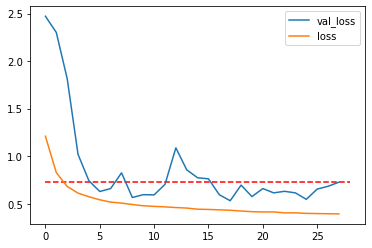

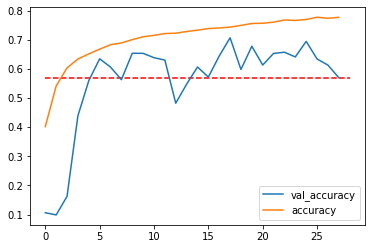

ValueError: ignored

In [15]:
from keras.models import load_model
plot_loss_acc()
model = load_model('test.hdf5')
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test_loss=", test_loss)
print("test_acc=", test_acc)

In [16]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [ ]:
#請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative
# model = load_model('test.hdf5')
# test_loss, test_acc = model.evaluate(X_test, y_test)
# y_pred = model.predict(X_test)
# S = np.zeros((10000,10))
# for i in range(10000):
#     S[i][np.argmax(y_pred[i])] = 1


In [ ]:
tn, fp, fn, tp = confusion.ravel()

In [ ]:
#labels = [(False, 0.75), (False, 1.0), (False, 1.25), (True, 0.75), (True, 1.0), (True, 1.25)]
#labels = ["adagrad", "sgd", "rmsprop", "adam"]
#L2_exp = [0.01, 0.001, 0.0001]
#drop = [0.125, 0.25, 0.5]
# batch = [64, 256, 512]
# plt.figure(figsize=(15,10))
# for i in range(3):
#     plt.plot(val_accuracy_score[i], "-", label=batch[i])
#     plt.plot(accuracy_score[i], "--", label=batch[i])
# plt.legend()
# plt.title("Accuracy")
# plt.show()

In [ ]:
# momentum >= 1, 會造成整體accuracy, val_accuracy在震盪後都大幅降低
# nesterov 正負不影響結果

In [ ]:
#Adam的表現在預設的參數之下表現最好

In [ ]:
#L2值越大，會更不容易overfitting，約L2 = 0.001較好

In [ ]:
#Dropout rate 在0.125時，有點overfiting，在0.25的時候train set 與val set的accuracy看起來很不錯，在0.5的時候有underfitting

In [ ]:
#batch size越小，收斂速度可能會越快64>256>512，但最後accuracy差異不大